In [2]:
import os
%pwd

'e:\\project_ineuron\\Air_Quality_Index_Predictor\\research'

In [3]:
os.chdir("../")
%pwd

'e:\\project_ineuron\\Air_Quality_Index_Predictor'

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error, mean_absolute_error
from itertools import product


e:\project_ineuron\Air_Quality_Index_Predictor\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
train_data = pd.read_csv(r"artifacts\data_transformation\train_dataset.csv", parse_dates=['date'])
test_data = pd.read_csv(r"artifacts\data_transformation\test_dataset.csv", parse_dates=['date'])


In [10]:
print(train_data.shape)
print(test_data.shape)

(21305, 9)
(1520, 9)


In [13]:
def plot_forecasts(train, test, predictions, title):
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train.values, label='Train')
    plt.plot(test.index, test.values, label='Test')
    plt.plot(test.index, predictions, label='Predictions', color='red', linestyle='--')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

def evaluate_forecast(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    return rmse, mae

def city_forecasting_with_plot(city, train, test, model_func, plot=True, **kwargs):
    train_city = train[train['city'] == city]
    test_city = test[test['city'] == city]
    
    train_city.set_index('date', inplace=True)
    test_city.set_index('date', inplace=True)
    
    train_series = pd.Series(train_city['AQI_calculated'])
    test_series = pd.Series(test_city['AQI_calculated'])

    train_series = train_series.resample(rule='W').mean()
    test_series = test_series.resample(rule='W').mean()
    
    forecast = model_func(train_series, test_series, **kwargs)
    if forecast is None:
        print(f"Warning: Forecast for AQI_calculated is None")
        return {}, {}
    
    forecasts = {'AQI_calculated': forecast}
    
    try:
        rmse, mae = evaluate_forecast(test_series, forecast)
        metrics = {'AQI_calculated': {'RMSE': rmse, 'MAE': mae}}
    except Exception as e:
        print(f"Error in evaluating forecast for AQI_calculated: {e}")
        return {}, {}
    
    if plot:
        plot_forecasts(train_series, test_series, forecast, title=f'{city} - AQI_calculated')
    
    return forecasts, metrics


## 1. Exponential Smoothing

In [22]:
# Exponential Smoothing (ETS)
def ets_forecast(train, test, seasonal='mul', seasonal_periods=52):
    model = ExponentialSmoothing(train, seasonal=seasonal, seasonal_periods=seasonal_periods)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast

Forecasting for Delhi using Exponential Smoothing (ETS)


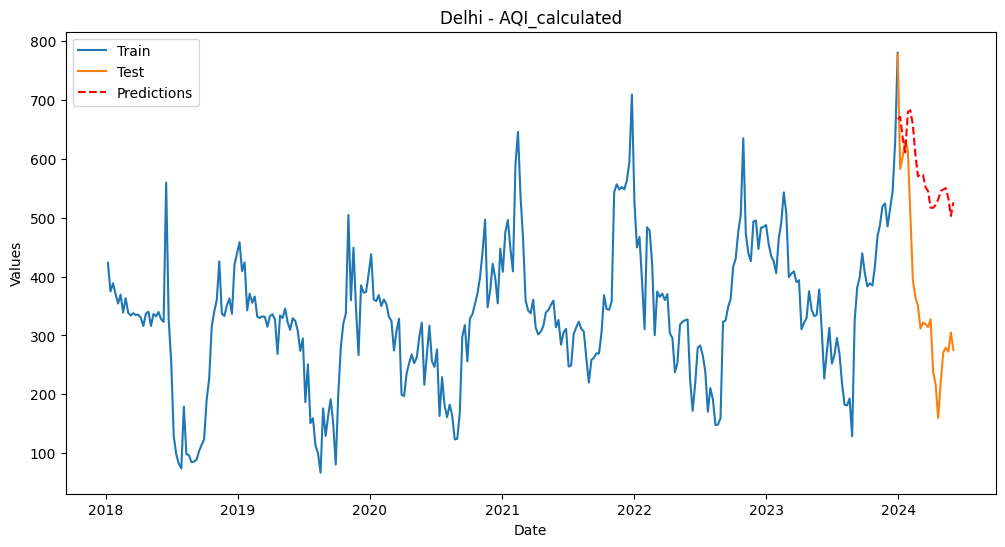

ETS Metrics: {'AQI_calculated': {'RMSE': 232.63725977845405, 'MAE': 214.1409226720291}}


In [23]:

# City to forecast
city_name = 'Delhi'

# Exponential Smoothing (ETS) Forecast
print(f"Forecasting for {city_name} using Exponential Smoothing (ETS)")
ets_forecasts, ets_metrics = city_forecasting_with_plot(city_name, train_data, test_data, ets_forecast, seasonal='add', seasonal_periods=52)
print("ETS Metrics:", ets_metrics)




## 2. Arima

In [25]:
from pmdarima import auto_arima

In [ ]:
auto_arima

In [63]:
# ARIMA
def arima_forecast(train, test, order=(5,1,0)):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast

Forecasting for Delhi using ARIMA


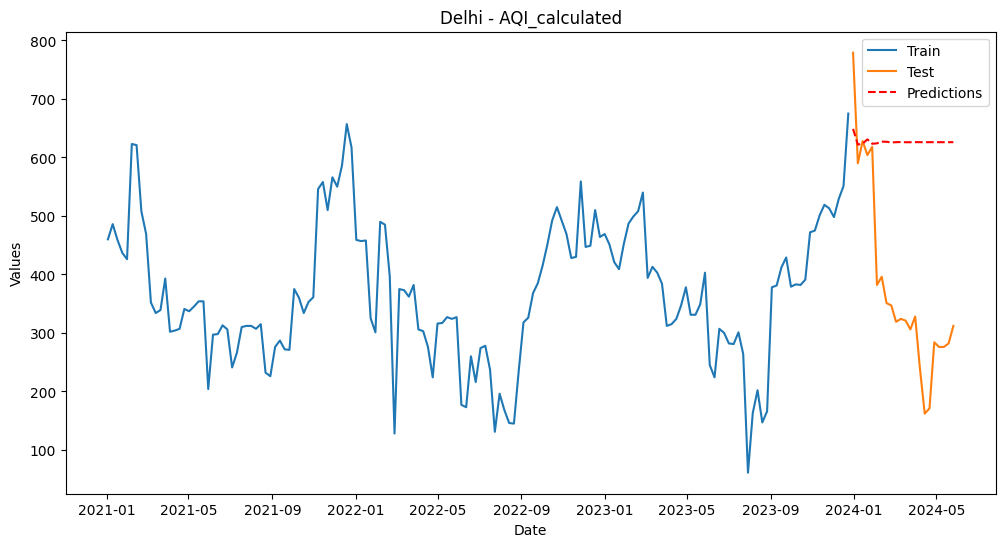

ETS Metrics: {'AQI_calculated': {'RMSE': 294.3157035785221, 'MAE': 262.05673808308387}}


In [64]:
# City to forecast
city_name = 'Delhi'

# Exponential Smoothing (ETS) Forecast
print(f"Forecasting for {city_name} using ARIMA")
ets_forecasts, ets_metrics = city_forecasting_with_plot(city_name, train_data, test_data, arima_forecast)
print("ETS Metrics:", ets_metrics)

### Improved

In [12]:
def arima_forecast_updated(train, test):
    p = range(0, 6)
    d = range(0, 3)
    q = range(0, 6)
    pdq = list(product(p, d, q))

    best_score = float('inf')
    best_params = None
    best_forecast = None

    for params in pdq:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model = ARIMA(train, order=params)
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=len(test))
                score = mean_squared_error(test, forecast)
                
                if score < best_score:
                    best_score = score
                    best_params = params
                    best_forecast = forecast
        except Exception as e:
            continue

    print(f"Best Parameters: {best_params}")
    return best_forecast

Forecasting for Delhi using Exponential Smoothing (ETS)
Best Parameters: (3, 0, 4)


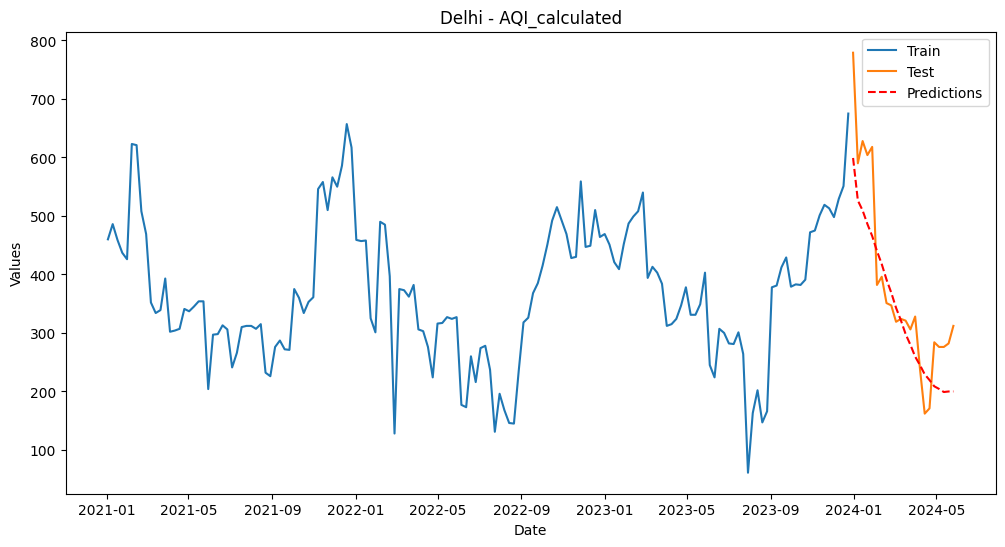

ETS Metrics: {'AQI_calculated': {'RMSE': 80.612035808917, 'MAE': 66.26149842073212}}


In [13]:

# Exponential Smoothing (ETS) Forecast
print(f"Forecasting for {city_name} using ARIMA")
ets_forecasts, ets_metrics = city_forecasting_with_plot(city_name, train_data, test_data, arima_forecast_updated)
print("ETS Metrics:", ets_metrics)

## 3. SARIMA

In [24]:

def sarima_forecast(train, test, order=(1,1,1), seasonal_order=(1,1,1,12)):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=len(test))
    return forecast


Forecasting for Delhi using SARIMA


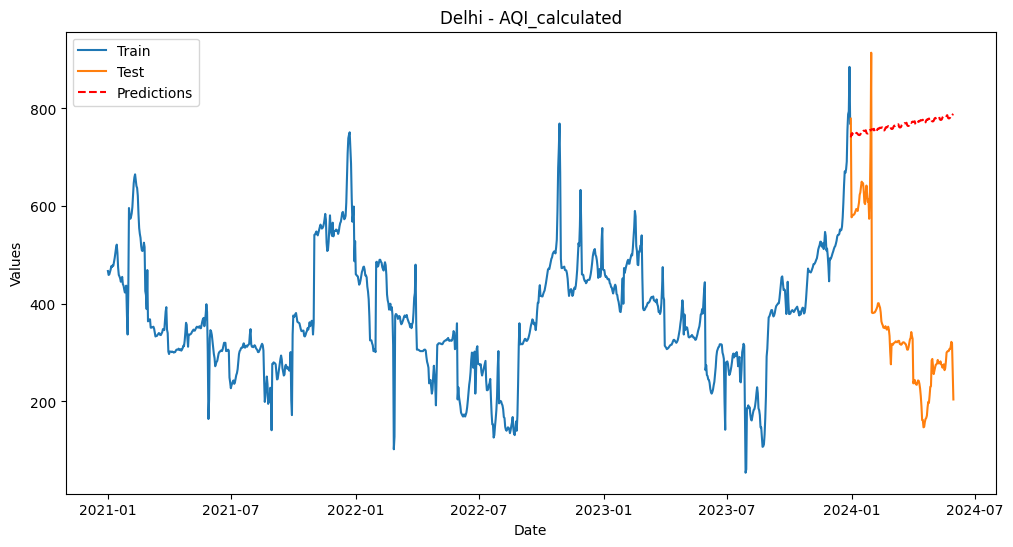

ETS Metrics: {'AQI_calculated': {'RMSE': 433.0533693686776, 'MAE': 406.1183153521099}}


In [25]:

print(f"Forecasting for {city_name} using SARIMA")
ets_forecasts, ets_metrics = city_forecasting_with_plot(city_name, train_data, test_data, sarima_forecast)
print("ETS Metrics:", ets_metrics)

In [31]:
def sarima_forecast_updated(train, test, order=(1,0,0), seasonal_order=(2,0,0,52)):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=len(test))
    return forecast

Forecasting for Delhi using SARIMA


d:\ML-Projects\03-Air-Quality-Index-Predictor\env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


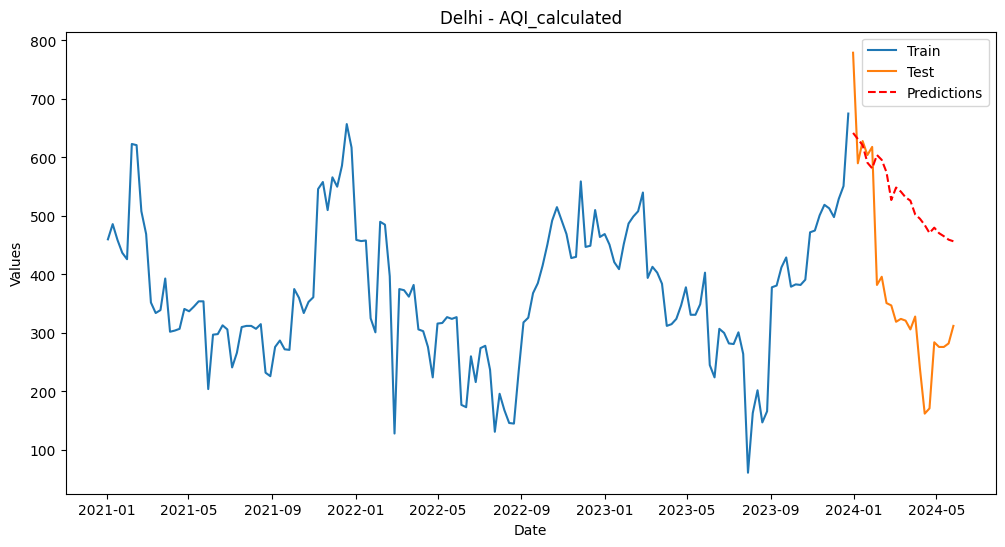

ETS Metrics: {'AQI_calculated': {'RMSE': 195.53493653595652, 'MAE': 176.99308344523286}}


In [33]:

print(f"Forecasting for {city_name} using SARIMA")
ets_forecasts, ets_metrics = city_forecasting_with_plot(city_name, train_data, test_data, sarima_forecast_updated)
print("ETS Metrics:", ets_metrics)

## 4. Prophet


In [35]:
def prophet_forecast(train, test):
    df = train.reset_index()
    df.columns = ['ds', 'y']
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)
    return forecast['yhat'][-len(test):].values

14:43:59 - cmdstanpy - INFO - Chain [1] start processing


Forecasting for Delhi using Prophet


14:44:00 - cmdstanpy - INFO - Chain [1] done processing


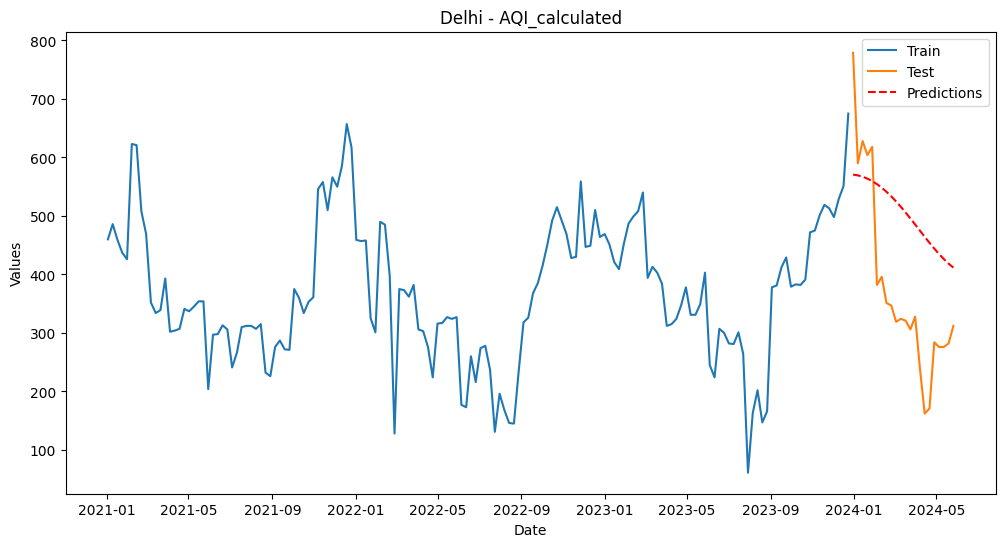

ETS Metrics: {'AQI_calculated': {'RMSE': 175.74384615595628, 'MAE': 161.17322887608947}}


In [36]:
print(f"Forecasting for {city_name} using Prophet")
ets_forecasts, ets_metrics = city_forecasting_with_plot(city_name, train_data, test_data, prophet_forecast)
print("ETS Metrics:", ets_metrics)

### Improved

In [43]:


from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
import numpy as np

def prophet_forecast_tuned(train, test):
    df_train = train.reset_index()
    df_train.columns = ['ds', 'y']
    df_test = test.reset_index()
    df_test.columns = ['ds', 'y']

    param_grid = {
        'changepoint_prior_scale': [0.05, 0.1, 0.5],
        'seasonality_prior_scale': [5, 10, 20],
        'n_changepoints': [10, 20, 30],
        'daily_seasonality': [True, False]
    }
    
    best_model = None
    best_mse = float('inf')  # Initialize with a high value

    for params in ParameterGrid(param_grid):
        model = Prophet(**params)
        model.fit(df_train)
        
        forecast = model.predict(df_test)
        mse = mean_squared_error(df_test['y'], forecast['yhat'])
        
        if mse < best_mse:
            best_mse = mse
            best_model = model

    future = best_model.make_future_dataframe(periods=len(df_test))
    forecast = best_model.predict(future)
    return forecast['yhat'][-len(df_test):].values


14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Delhi using Prophet


14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing
14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing
14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing
14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing
14:55:14 - cmdstanpy - INFO - Chain [1] start processing
14:55:14 - cmdstanpy - INFO - Chain [1] done processing
14:55:14 - cmdstanpy - INFO - Chain [1] start processing
14:55:14 - cmdstanpy - INFO - Chain [1] done processing
14:55:14 - cmdstanpy - INFO - Chain [1] start processing
14:55:14 - cmdstanpy - INFO - Chain [1] done processing
14:55:14 - cmdstanpy - INFO - Chain [1] start processing
14:55:14 - cmdstanpy - INFO - Chain [1] done processing
14:55:14 - cmdstanpy - INFO - Chain [1] start processing
14:55:14 - cmdstanpy - INFO - Chain [1]

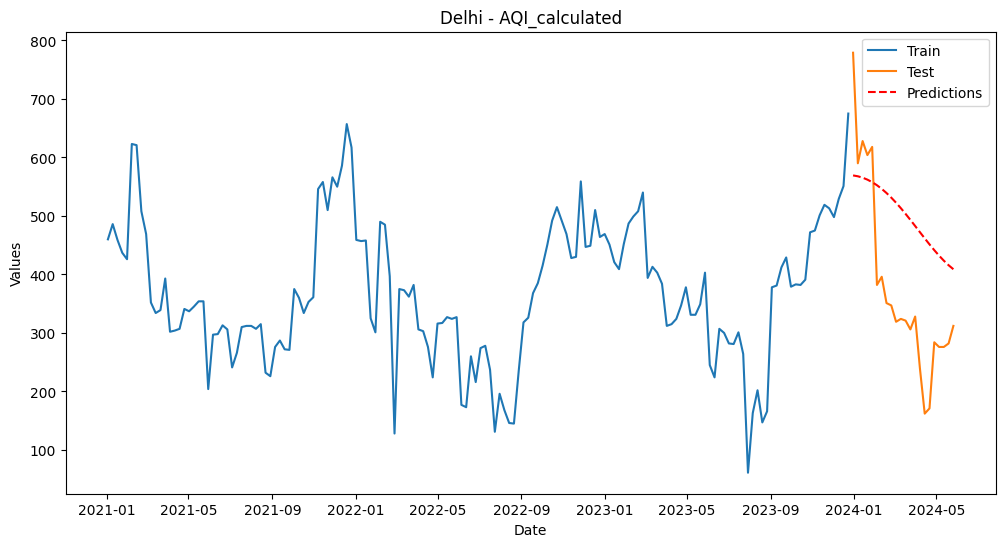

ETS Metrics: {'AQI_calculated': {'RMSE': 173.90187730380106, 'MAE': 159.6433410022417}}


In [45]:
print(f"Forecasting for {city_name} using Prophet")
ets_forecasts, ets_metrics = city_forecasting_with_plot(city_name, train_data, test_data, prophet_forecast_tuned)
print("ETS Metrics:", ets_metrics)